# Cycle-GAN

### 本章節內容大綱
* [Build a CyclaGAN Model](#Build-a-CyclaGAN-Model)
* [Cycle Loss](#Cycle-Loss)

<br>
<img src='https://hackmd.io/_uploads/SJCVx-6g6.jpg' width=700  />

相較於conditional GAN需要一組的paired data來訓練模型，cycle GAN並不需要paired data，或是說，當我們無法取得paired data的時候，就可以使用cycle GAN。(像是要把照片的風格轉換成莫內的風格，但是莫內早已不在人世，我們就沒辦法得到對應於照片的畫作)

## Import

In [1]:
# 下載 yosemite dataset 所需要的套件
!pip install tensorflow_datasets

In [2]:
# 使用 instance normalization 所需要的套件
!pip install tensorflow-addons

In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Conv2DTranspose, Conv2D, BatchNormalization,
    ReLU, LeakyReLU, Dropout, Reshape, Activation, add, concatenate
)
from tensorflow.keras.initializers import glorot_uniform
from tensorflow_addons.layers import InstanceNormalization

import tensorflow_datasets as tfds


import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
len(tf.config.experimental.list_physical_devices('GPU'))

1

## Preparing data

In [ ]:
# 上傳資料
!wget -q https://github.com/TA-aiacademy/course_3.0/releases/download/v2.5_gan/GAN_part3.zip
!unzip -q GAN_part3.zip

In [3]:
CLASS_MAP = {'trainA':0, 'trainB':1, 'testA':0, 'testB':1}
def paths2labels(paths):
    return [CLASS_MAP[p.split(os.sep)[-2]] for p in paths]

# 影像讀取 & resize
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    return image

# 使用路徑建構 tf.data.Dataset
def build_ds(paths):
    labels = paths2labels(paths) # paths -> labels
    image_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_ds = image_ds.map(lambda path, label: (load_image(path), label)) # path -> img, labels
    image_ds = image_ds.prefetch(AUTOTUNE)
    return image_ds

In [4]:
image_dir = glob.glob('summer2winter_yosemite/*/*.jpg')
metadata_dict = dict()

for i in image_dir:
    _, dirs, files = i.split('/')
    if dirs not in metadata_dict:
        metadata_dict[dirs] = [i]
    else:
        metadata_dict[dirs].append(i)

In [5]:
train_summer, train_winter = build_ds(metadata_dict['trainA']), build_ds(metadata_dict['trainB'])
test_summer, test_winter = build_ds(metadata_dict['testA']), build_ds(metadata_dict['testB'])

2023-10-04 17:41:20.912543: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 17:41:21.553640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0c:00.0, compute capability: 6.1


In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 4
IMG_WIDTH = 256
IMG_HEIGHT = 256

LAMBDA_cycle = 10  # cycle loss 的權重
LAMBDA_identity = 0.5  # identity loss 的權重

EPOCHS = 200
epoch_decay = 100  # 在 100 個 epoches 後 weight decay

In [7]:
def random_crop(image):
    cropped_image = tf.image.random_crop(
        image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image


# 將圖片正規化到 [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image


def random_jitter(image):

    # resize 到 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # 隨機 crop 到 256 x 256 x 3
    image = random_crop(image)

    # 隨機翻轉
    image = tf.image.random_flip_left_right(image)

    return image

In [8]:
def preprocess_image_train(image, label):
    # 'label' 這個參數是為了接原本圖片有多一個label的維度（這邊不需要使用label）
    image = random_jitter(image)
    image = normalize(image)
    return image


def preprocess_image_test(image, label):
    image = normalize(image)
    return image

In [9]:
# cache 可以將 data 先讀入 memory 加快速度
# num_parallel_calls 是一次準備多少圖片一起處理，AUTOTUNE 是我們前面有定義的變數，他可以最佳化到底要讀多少圖的這個參數

train_summer = train_summer.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_winter = train_winter.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_summer = test_summer.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_winter = test_winter.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

2023-10-04 17:41:22.462798: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


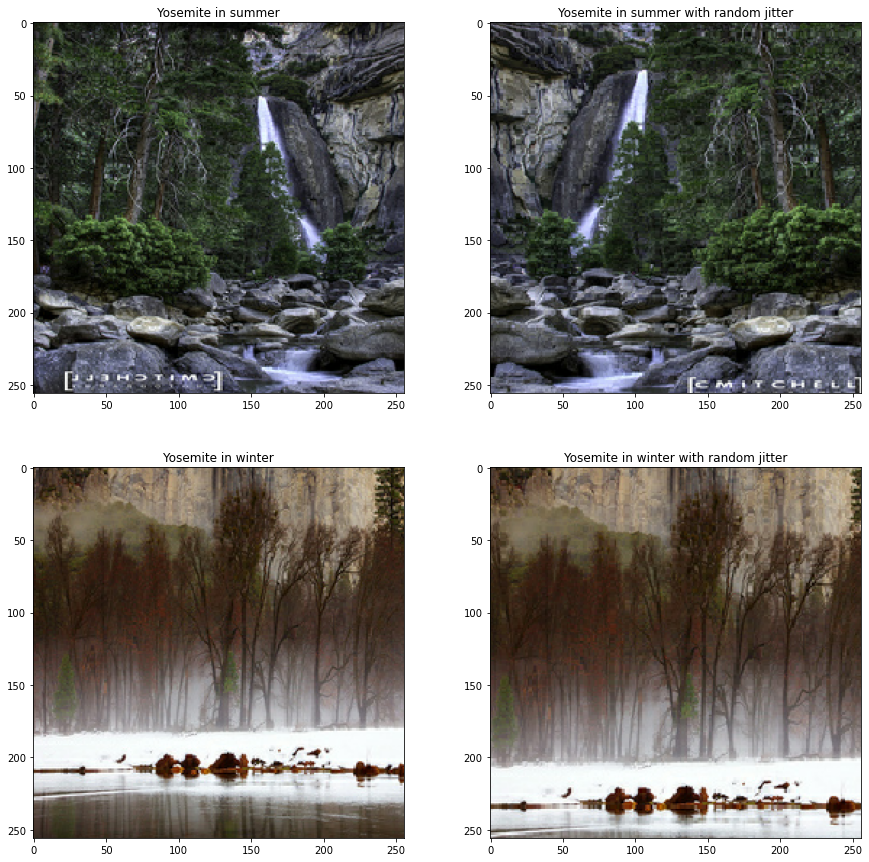

In [10]:
sample_summer = next(iter(train_summer))[0]
sample_winter = next(iter(train_winter))[0]

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('Yosemite in summer')
plt.imshow(sample_summer * 0.5 + 0.5)

plt.subplot(2,2,2)
plt.title('Yosemite in summer with random jitter')
plt.imshow(random_jitter(sample_summer) * 0.5 + 0.5)

plt.subplot(2,2,3)
plt.title('Yosemite in winter')
plt.imshow(sample_winter * 0.5 + 0.5)

plt.subplot(2,2,4)
plt.title('Yosemite in winter with random jitter')
plt.imshow(random_jitter(sample_winter) * 0.5 + 0.5)

## Build a CycleGAN Model

與Pix2Pix不一樣，CycleGAN因為是unpaired data的訓練，所以需要各兩個Generator與Discriminator一起訓練，

兩個Generators : G 與 F ，的任務分別是將X Domain轉成Y Domain與將Y Domain轉成X Domain，

而Discriminators的任務也一樣，要判別這兩個Domain的資料到底是真實的還是生成的。
##### 模型的結構上與Pix2Pix不同的部分有：
- Normalize的部分使用了Instance Normalization而非Batch Normalization（因為Batch_size = 1）
- 整體的結構使用了resnet為基底的Generator而非Unet


<br>
<img src='https://hackmd.io/_uploads/Hy2Peb6lp.png'>

In [11]:
def identity_block(X, f, filters):

    # 儲存 input 來作 skip connection
    X_shortcut = X

    X = tf.pad(X, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
    X = Conv2D(filters=filters, kernel_size=(f, f), strides=(1, 1),
               padding='valid', use_bias=False)(X)
    X = InstanceNormalization()(X)
    X = ReLU()(X)

    X = tf.pad(X, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
    X = Conv2D(filters=filters, kernel_size=(f, f), strides=(1, 1),
               padding='valid', use_bias=False)(X)
    X = InstanceNormalization()(X)

    # 將 output 與 input 合在一起
    X = add([X, X_shortcut])

    return X


def Conv(X, f, s, filters, leaky=False, padding='same'):

    if padding == 'same':
        conv = Conv2D(filters, (f, f), padding='same', use_bias=False, strides=(s, s))(X)
    elif padding == 'valid':
        conv = Conv2D(filters, (f, f), padding='valid', use_bias=False, strides=(s, s))(X)

    conv = InstanceNormalization()(conv)

    if leaky:
        conv = LeakyReLU(alpha=0.2)(conv)
    else:
        conv = ReLU()(conv)
    return conv

In [12]:
def ResGen(input_size=(256, 256, 3), n_blocks=9):

    inputs = Input(input_size)
    # ======================Encoder======================

    # batch 與 channel 不需要 padding
    X = tf.pad(inputs, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")

    X = Conv(X, 7, 1, 64, leaky=False, padding='valid')  # (256,256,64)

    X = Conv(X, 3, 2, 128, leaky=False)  # (128,128,128)

    X = Conv(X, 3, 2, 256, leaky=False)  # (64,64,256)

    # ====================Encoder end====================

    for i in range(n_blocks):
        X = identity_block(X, 3, 256)

    # ====================Decoder========================

    X = Conv2DTranspose(128, (3, 3), strides=(2, 2),
                        padding='same', use_bias=False)(X)  # (128,128,128)
    X = InstanceNormalization()(X)
    X = ReLU()(X)

    X = Conv2DTranspose(64, (3, 3), strides=(2, 2),
                        padding='same', use_bias=False)(X)  # (256,256,64)
    X = InstanceNormalization()(X)
    X = ReLU()(X)

    X = tf.pad(X, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")
    X = Conv2D(3, (7, 7), padding='valid', activation='tanh')(X)  # (256,256,3)

    # ======================Decoder end==========================

    return Model(inputs=[inputs], outputs=[X])

In [13]:
def Disc(input_size=(256, 256, 3), n_blocks=1):
    inputs = Input(input_size)

    # ======================Encoder======================

    X = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    X = LeakyReLU(alpha=0.2)(X)

    X = Conv(X, 4, 2, 128, leaky=True)

    X = Conv(X, 4, 2, 256, leaky=True)

    X = Conv(X, 4, 1, 512, leaky=True)

    # ======================Encoder end======================

    X = Conv2D(1, (4, 4), padding='same', activation=None)(X)

    return Model(inputs=[inputs], outputs=[X])

In [14]:
generator_g = ResGen()
generator_f = ResGen()

discriminator_x = Disc()
discriminator_y = Disc()

2023-10-04 17:41:25.552873: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


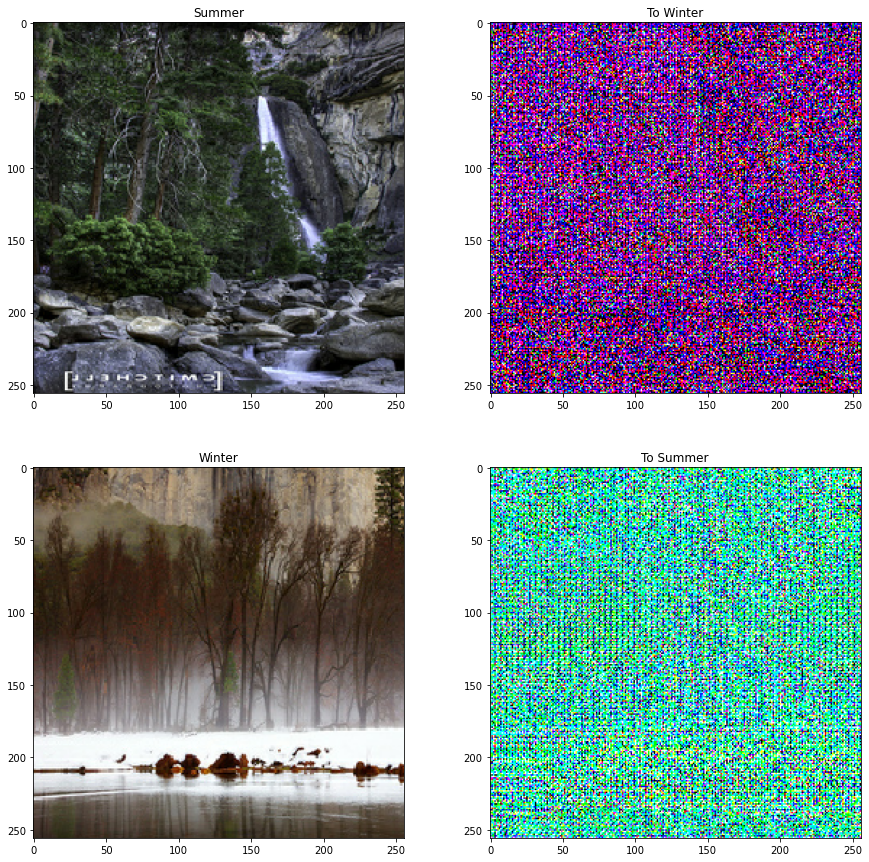

In [15]:
# 檢查 Generator 的 output
to_winter = generator_g(sample_summer[tf.newaxis, ...])[0]
to_summer = generator_f(sample_winter[tf.newaxis, ...])[0]
plt.figure(figsize=(15, 15))
contrast = 8

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ['Summer', 'To Winter', 'Winter', 'To Summer']

# 畫出 generator 的 output
for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i] * 0.5 + 0.5)  # rescale value to [0-1]
    else:
        plt.imshow(imgs[i] * 0.5 * contrast + 0.5)
plt.show()

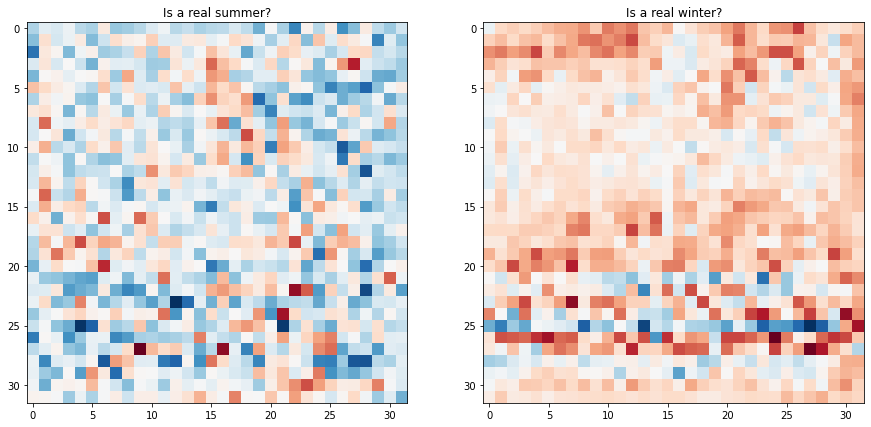

In [16]:
# 檢查 Discriminator 的 output
# 越紅越接近 0，越藍越接近 1
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.title('Is a real summer?')
plt.imshow(discriminator_x(sample_summer[tf.newaxis, ...])[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real winter?')
plt.imshow(discriminator_y(sample_winter[tf.newaxis, ...])[0, ..., -1], cmap='RdBu_r')

plt.show()

## Cycle Loss

在CycleGAN裡面，由於沒有paired data的緣故，所以我們無法保證從generator output出來的圖片是原圖轉換風格還是只是隨便一張能騙過Discriminator的圖。所以為了要強制generator能夠學到另一個風格並且還能維持原本的圖片語意，作者提出了 cycle consistency loss。簡單來說，就是把input $X$ 丟進 $X\rightarrow Y$ 的generator再丟進 $Y\rightarrow X$ 的generator最後得到 $\hat{X}$ ，計算 $X$ 與 $\hat{X}$ 之間的差異就是cycle consistency loss。

<br>
<img src='https://hackmd.io/_uploads/HJSYgZTla.png'>

In [17]:
# 這裡使用 lsgan 的 loss function
loss_obj = tf.losses.MeanSquaredError()


def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [18]:
# Cycle loss 是將 X 轉為 fake_Y 後，再將 fake_Y 轉回 X_cycle
# 計算 X 與 X_cycle 的差異來得到 cycle consistency loss
def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA_cycle * loss


# Identity loss 即將 X 丟進 Y -> X 的 generator 後得到的 X_hat，應該也要跟 X 一樣而非胡亂轉換，
# 效果類似提供一個 identity mapping 的參考
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA_identity * loss

In [19]:
class LinearDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    # 如果目前的 step < step_dacay 就使用原本的 learning rate
    # 否則會以線性的衰退來挑整 learning rate 直至 0

    def __init__(self, initial_learning_rate, total_steps, step_decay):
        super(LinearDecay, self).__init__()
        self._initial_learning_rate = initial_learning_rate
        self._steps = total_steps
        self._step_decay = step_decay
        self.current_learning_rate = tf.Variable(initial_value=initial_learning_rate,
                                                 trainable=False, dtype=tf.float32)

    def __call__(self, step):
        self.current_learning_rate.assign(tf.cond(
            step >= self._step_decay,
            true_fn=lambda: self._initial_learning_rate * (1 - 1 / (self._steps - self._step_decay) *
                                                           (step - self._step_decay)),
            false_fn=lambda: self._initial_learning_rate
        ))
        return self.current_learning_rate

In [20]:
lr_scheduler = LinearDecay(2e-4,  EPOCHS * BUFFER_SIZE, epoch_decay * BUFFER_SIZE)

generator_g_optimizer = tf.keras.optimizers.Adam(lr_scheduler, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(lr_scheduler, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(lr_scheduler, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(lr_scheduler, beta_1=0.5)

In [21]:
checkpoint_path = "./training_checkpoints"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)  # 最多存 5 組 weight

# 如果有 checkpoint ，載入其權重
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [22]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [23]:
@tf.function
def train_step(real_x, real_y):

    # 當 tape 被拿來計算 graident 就會被記憶體釋放，persistent 可以避免被釋放
    # 通常用於計算多個 gradient 時使用
    with tf.GradientTape(persistent=True) as tape:

        # Generator G translates X -> Y
        # Generator F translates Y -> X

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # output discriminator logits
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # same_x 、 same_y 用來計算 identity loss
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # 計算 cycle loss
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss + identity loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # 分別計算 gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss,
                                          generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss,
                                          generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss,
                                              discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss,
                                              discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                              generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                              generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                  discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                  discriminator_y.trainable_variables))
    
    return total_gen_g_loss, total_gen_f_loss, disc_y_loss, disc_x_loss

.........................
Summer2Winter G_loss: 36786.91016, Winter2Summer G_loss: 24386.16602
Summer2Winter D_loss: 49235.06641, Winter2Summer D_loss: 39220.92969
Time taken for epoch 1 is 349.7764995098114 sec

.........................

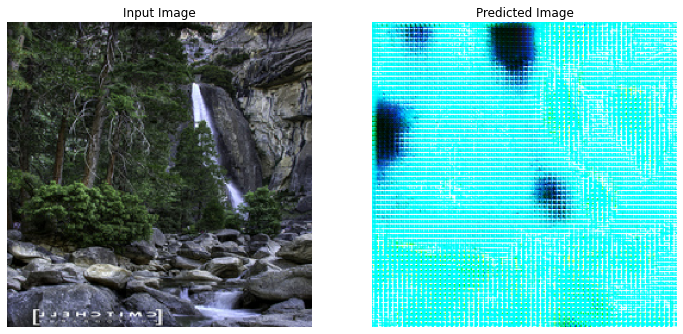


Summer2Winter G_loss: 45743.02344, Winter2Summer G_loss: 28898.37695
Summer2Winter D_loss: 57200.46875, Winter2Summer D_loss: 48616.93750
Time taken for epoch 2 is 296.57272124290466 sec

.........

KeyboardInterrupt: 

In [24]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_summer, train_winter)):
        s2w_Gloss, w2s_Gloss, y_Dloss, x_Dloss = train_step(image_x, image_y)
        if n % 10 == 0:
            print('.', end='')
        n+=1

    # 利用一樣的照片 (sample_summer) 來觀察模型學習的效果
    if (epoch + 1) % 2 == 0:
        generate_images(generator_g, sample_summer[tf.newaxis, ...])

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('')
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                            ckpt_save_path))
    print('')
    print('Summer2Winter G_loss: %.5f, Winter2Summer G_loss: %.5f' % (s2w_Gloss, w2s_Gloss))
    print('Summer2Winter D_loss: %.5f, Winter2Summer D_loss: %.5f' % (y_Dloss, x_Dloss))
    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                       time.time()-start))

.........................
Summer2Winter G_loss: 41676.65625, Winter2Summer G_loss: 20973.78711
Summer2Winter D_loss: 54729.97656, Winter2Summer D_loss: 36100.19531
Time taken for epoch 1 is 339.94370126724243 sec

.........................

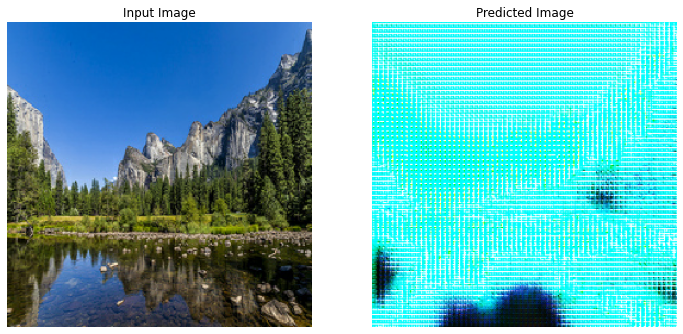


Summer2Winter G_loss: 45083.01953, Winter2Summer G_loss: 28364.27930
Summer2Winter D_loss: 54029.07422, Winter2Summer D_loss: 48240.78906
Time taken for epoch 2 is 288.0391438007355 sec

........

KeyboardInterrupt: 

In [24]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_summer, train_winter)):
        s2w_Gloss, w2s_Gloss, y_Dloss, x_Dloss = train_step(image_x, image_y)
        if n % 10 == 0:
            print('.', end='')
        n+=1

    # 利用一樣的照片 (sample_summer) 來觀察模型學習的效果
    if (epoch + 1) % 2 == 0:
        generate_images(generator_g, sample_summer[tf.newaxis, ...])

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('')
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                            ckpt_save_path))
    print('')
    print('Summer2Winter G_loss: %.5f, Winter2Summer G_loss: %.5f' % (s2w_Gloss, w2s_Gloss))
    print('Summer2Winter D_loss: %.5f, Winter2Summer D_loss: %.5f' % (y_Dloss, x_Dloss))
    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                       time.time()-start))

## Check result(After 200 epoches training, ~12hrs)


In [ ]:
# summer to winter
for inp in test_summer.take(5):
    generate_images(generator_g, inp)

In [ ]:
# winter to summer
for inp in test_winter.take(5):
    generate_images(generator_f, inp)